In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib ipympl # for interactive plots
from pathlib import Path
import seaborn as sns
import umap
import time
import skdim
#import tensorflow as tf
#from tensorflow.keras import layers, models
#from keras_tuner import HyperModel, RandomSearch
from spatialinfo import spatial_information as si
from spatialinfo import dimensionality_utils as du
from spatialinfo import decoder as dc
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm


## LOAD DATA

In [2]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
activity_data, spatial_data = si.temporal_binning(dff, bh, sec_per_bin=0.5, only_moving=False)

In [3]:
np.shape(activity_data)

(3697, 366)

## COMPUTE DIMENSIONALITY
The angle-based intrinsic dimensionality (ABID) estimate was introduced by [Thordsen & Schubert (2022)](https://doi.org/10.1016/j.is.2022.101989). In short, for each point of a dataset x nearest neighbors are found according to some distance metric. From the paper:

"Definition 1 (ABID) . Given a data set $X = { x_1 , . . . , x_n }⊂ \mathbb{R}^D$ , the regularized angle-based intrinsic dimensionality estimator for a point x i is: $ID_{ABID}( x_i ; k ) := \mathbb{E} [ C_1 ( B_k ( x_i ))^2 ] ^{− 1}$ where $B_k ( x_i )$ are the directional vectors from $x_i$ to the k nearest neighbors of $x_i$ and $C_1 ( B_k ( x_i ))$ are the pairwise cosine similarities within $B_k ( x_i )$."

In [4]:

abid_dim = du.compute_abids(activity_data)
print(f"ABID: {np.nanmean(abid_dim):.2f}", end='', flush=True)
time.sleep(.2)
    
mom_dim = skdim.id.MOM().fit_transform(activity_data,n_neighbors = 25)
print(f" | MOM: {mom_dim:.2f}", end='', flush=True)
time.sleep(.2)

tle_dim = skdim.id.TLE().fit_transform(activity_data,n_neighbors = 25)
print(f" | TLE: {tle_dim:.2f}", flush=True)
time.sleep(.2)

ABID: 3.72

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical}

 | MOM: 9.10 | TLE: 8.15


In [5]:
# Dependency of ABID to temporal bin size - takes 28 minutes on a CPU
ABID_dep = []
for temp_bin in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]:
    activity_data_dep, spatial_data_dep = si.temporal_binning(dff, bh, sec_per_bin=temp_bin, only_moving=False)
    abid_dim_dep = du.compute_abids(activity_data_dep)
    ABID_dep.append(np.mean(abid_dim_dep))

plt.plot([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1], ABID_dep)

KeyboardInterrupt: 

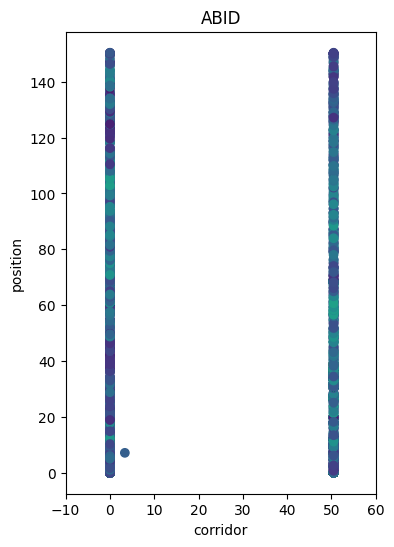

In [5]:
# display how ABID maps to behavior space

df = np.column_stack((spatial_data, abid_dim))

fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=df[:,0], y=df[:,1], c=df[:,2], cmap='viridis')
ax.set(title='ABID', xlabel='corridor', ylabel='position')
ax.set_xlim([-10,60])
plt.show()

## COMPUTE UMAP

In [4]:
#model = umap.UMAP(n_neighbors =50, n_components =3, min_dist=0.08, metric="correlation")
model = umap.UMAP(n_neighbors =30, n_components =3, min_dist=0.1, metric="correlation")
model.fit(activity_data)
concat_emb = model.transform(activity_data)
np.shape(spatial_data)

(3697, 2)

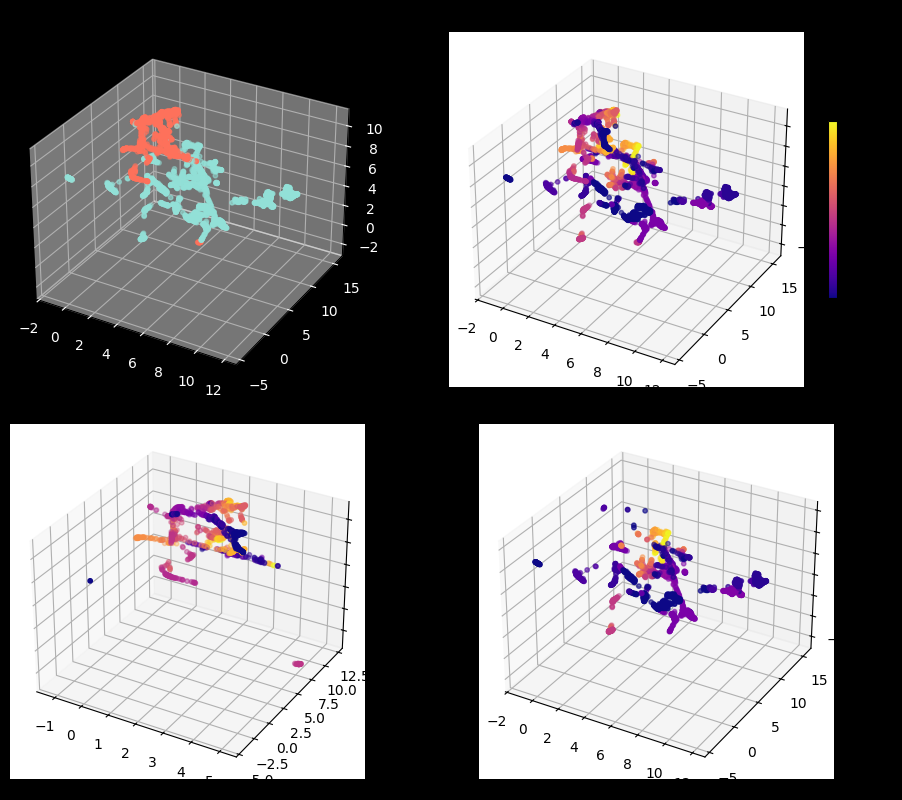

In [8]:
# Normalize x and y separately for color mapping
norm_x = Normalize(vmin=spatial_data[:, 0].min(), vmax=spatial_data[:, 0].max())
norm_y = Normalize(vmin=spatial_data[:, 1].min(), vmax=spatial_data[:, 1].max())

colors_x = cm.viridis(norm_x(spatial_data[:, 0]))  # Color by x
colors_y = cm.plasma(norm_y(spatial_data[:, 1]))  # Color by y

# Filter points where x = 0 and x ≠ 0
mask_x0 = spatial_data[:, 0] == 0
mask_x_nonzero = spatial_data[:, 0] != 0



# Create figure and 3D subplots
fig = plt.figure(figsize=(10, 8), facecolor='black')

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(221, projection='3d', facecolor='black')
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_rgb, s=10)
ax1.set_title("Color-coded by X-position")
# Set white for all axis lines and ticks
ax1.tick_params(colors='white')  # Ticks
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.zaxis.label.set_color('white')


# Add colorbar for x
#sm_x = cm.ScalarMappable(cmap="viridis", norm=norm_x)
#sm_x.set_array([])
#cbar_x = plt.colorbar(sm_x, ax=ax1, shrink=0.5)
#cbar_x.set_label("X Position")

# Subplot 2: Color-coded by y-position
ax2 = fig.add_subplot(222, projection='3d')
sc2 = ax2.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_y, s=10)
ax2.set_title("Color-coded by Y-position")


# Add colorbar for y
sm_y = cm.ScalarMappable(cmap="plasma", norm=norm_y)
sm_y.set_array([])
cbar_y = plt.colorbar(sm_y, ax=ax2, shrink=0.5)
cbar_y.set_label("Y Position")

# Subplot 3: Only x = 0, color-coded by y-position
ax3 = fig.add_subplot(223, projection='3d')
sc3 = ax3.scatter(concat_emb[mask_x0, 0], concat_emb[mask_x0, 1], concat_emb[mask_x0, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x0, 1])), s=10)
ax3.set_title("Only X = 0, Color-coded by Y")


# Subplot 4: Only x ≠ 0, color-coded by y-position
ax4 = fig.add_subplot(224, projection='3d')
sc4 = ax4.scatter(concat_emb[mask_x_nonzero, 0], concat_emb[mask_x_nonzero, 1], concat_emb[mask_x_nonzero, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x_nonzero, 1])), s=10)
ax4.set_title("Only X ≠ 0, Color-coded by Y")


plt.tight_layout()
plt.show()

In [7]:
# Threshold X to assign binary groups (e.g., midpoint split)
x_values = spatial_data[:, 0]
x_threshold = np.median(x_values)  # or pick a manual value
labels_x = x_values < x_threshold  # True for "right", False for "left"

# Define your two colors
teal = (0/255, 128/255, 128/255)
red = (200/255, 50/255, 50/255)

new_red = (255/255, 113/255, 91/255)
new_teal = (147/255, 225/255, 216/255)

# Map binary labels to RGB colors
colors_rgb = np.where(labels_x[:, None], new_red, new_teal)

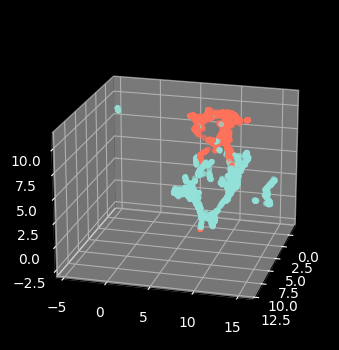

In [27]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(4, 4), facecolor='black')

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(111, projection='3d', facecolor='black')
ax1.view_init(elev=20, azim=15)  # 20° above, 45° rotated horizontally
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_rgb, s=10)
ax1.set_title("Color-coded by X-position")
# Set white for all axis lines and ticks
ax1.tick_params(colors='white')  # Ticks
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.zaxis.label.set_color('white')
plt.savefig("../results/Dc_UMAP_new.png")



Another way to look at dimensionality of a dataset would be to look at the loadings of the principal components after projecting the data on orthogonal axes.

In [40]:
# start by MinMax-Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(activity_data.T)# Now, shape (n_samples, n_neurons)
# fit PCA transform
pca = PCA()
pca.fit(X)

PCA()

Text(0, 0.5, 'explained variance ratio')

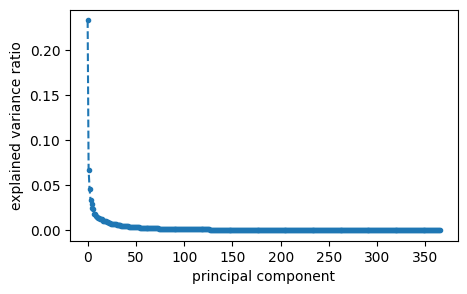

In [41]:
plt.figure(figsize=(5,3))
plt.plot(pca.explained_variance_ratio_, '.--')
plt.xlabel("principal component")
plt.ylabel("explained variance ratio")

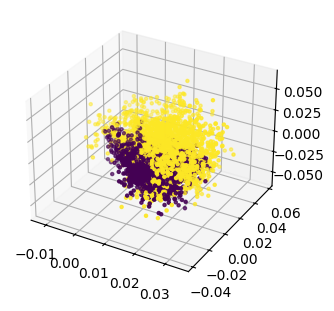

In [63]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(10, 8))

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(pca.components_.T[:, 0], pca.components_.T[:, 2], pca.components_.T[:, 3], c=colors_x, s=5)

# Remove axes, labels, and title
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.set_zticks([])
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
#ax1.set_zticklabels([])
#ax1.set_frame_on(False)
#ax1.grid(False)
#ax1.xaxis.pane.fill = False
#ax1.yaxis.pane.fill = False
#ax1.zaxis.pane.fill = False
#ax1.set_title("")  # Remove title
#ax1.axis('off')  # This removes all spines and ticks

plt.show()